# Deep Fruit Detection in Orchards
### In this notebook we reproduced the paper "Deep Fruit Detection in Orchards". We load in the images and annotations, train a network with different backbones and evaluate the results.

In [1]:
# What to use notebook for?
train_zf = 0
train_vgg = 0

In [2]:
## Imports
from PIL import Image
import numpy as np
import datetime
import pickle
import os

# Torch
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import nms
import torch.nn as nn
import torchvision
import torch

# Import Helper Files
import sys ; sys.path.append('Helper_files/')
from engine import train_one_epoch, evaluate
from utils import collate_fn

# Get clean cell outputs
import warnings
warnings.filterwarnings("ignore", message="genfromtxt")

# Plots
import matplotlib.patches as patches
from matplotlib import container
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

# Devices
device_cpu = torch.device('cpu')
device = torch.device('cuda')

In [3]:
class AppleDataset(Dataset):
    """Apple dataset."""

    def __init__(self, root_dir):
        """
        Args:
            root (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root = root_dir
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "Images")))) # Sort images
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "Annotations")))) # Sort annotations
        self.transform = transforms.Compose([transforms.Resize( (500, 762) ) , transforms.ToTensor()]) # Rescale and transform to tensor

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        
        # LOAD DATA AND ANNOTATIONS
        img_path = os.path.join(self.root, "Images", self.imgs[idx]) # Path to images
        annot_path = os.path.join(self.root, "Annotations", self.annots[idx]) # # Path to annotations
        
        img = Image.open(img_path) # Load Image
        annot_data = np.genfromtxt(annot_path, delimiter=',') # Load Annotations
        
        if annot_data.size == 0:
            annot_data.resize( (1, 5), refcheck=False)
            annot_data = annot_data[~np.all(annot_data == 0, axis=1)]

        if annot_data.size == 5:
            annot_data.resize( (1, 5), refcheck=False)

        # TRANSFORM ANNOTATIONS
        annot_data[:, 1] = annot_data[:, 1] - annot_data[:, 3]
        annot_data[:, 2] = annot_data[:, 2] - annot_data[:, 3]
        annot_data[:,3] *= 2
        annot_data = np.insert(annot_data, 4, annot_data[:,3], axis=1)
        annot_data[:,4] = annot_data[:,2] + annot_data[:,3]
        annot_data[:,3] = annot_data[:,1] + annot_data[:,3]
        annot_data[:, 1:5] = annot_data[:, 1:5] * (500/202) # Rescale for new images
        
        boxes = annot_data[:, 1:5] # Extraxt bounding boxes
        boxes = torch.from_numpy(boxes)
        
        labels = annot_data[:, 5] # Extract labels
        labels = torch.from_numpy(labels).to(torch.int64)
        
        image_id = torch.tensor([idx]) # Tensor with image ID
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # Area of bounding box
        iscrowd = torch.zeros((len(labels)), dtype=torch.int64)
        
        # TENSORS TO GPU
        boxes.to(device)
        labels.to(device)
        image_id.to(device)
        iscrowd.to(device)
        
        target = {'boxes': boxes, 'labels': labels, 'image_id': image_id, 'area':area, 'iscrowd': iscrowd}
        img = self.transform(img) # Rescale and transform image
        
        return img, target

In [4]:
# CREATE DATASET
dataset = AppleDataset('Apples/')
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn, pin_memory=False)

In [5]:
# Function to visualise data
def Visualise_Image(image, targets, predictions_vgg = None, predictions_zf = None):
    im = transforms.ToPILImage()(images[0]) # Prepare image
    
    fig, ax = plt.subplots() # Create figure
    ax.imshow(im) # Show image
    
    if predictions_vgg is not None:
        for i in range(predictions_vgg.shape[0]):
            rect_pred = patches.Rectangle( (predictions_vgg[i][0], predictions_vgg[i][1]), 
                                            predictions_vgg[i][2] - predictions_vgg[i][0] , 
                                            predictions_vgg[i][3] - predictions_vgg[i][1], 
                                            linewidth=1, edgecolor='r', facecolor='none')           # Visualise bounding box
       
            ax.add_patch(rect_pred) # Plot bounding box
        
    if predictions_zf is not None:
        for i in range(predictions_zf.shape[0]):
            rect_pred = patches.Rectangle( (predictions_zf[i][0], predictions_zf[i][1]), 
                                            predictions_zf[i][2] - predictions_zf[i][0] , 
                                            predictions_zf[i][3] - predictions_zf[i][1], 
                                            linewidth=1, edgecolor='y', facecolor='none')           # Visualise bounding box
       
            ax.add_patch(rect_pred) # Plot bounding box
    
    for i in range(targets["boxes"].shape[0]):
        rect = patches.Rectangle( (targets["boxes"][i][0], targets["boxes"][i][1]), 
                                   targets["boxes"][i][2] - targets["boxes"][i][0] , 
                                   targets["boxes"][i][3] - targets["boxes"][i][1], 
                                   linewidth=1, edgecolor='b', facecolor='none')           # Visualise bounding box
    
        ax.add_patch(rect) # Plot bounding box

In [6]:
# VISUALIZE DATA
images, targets = next(iter(data_loader)) # Load next data
Visualise_Image(images, targets[0], predictions_vgg = None, predictions_zf = None)


In [7]:
# OWN IMPLEMENTED ZF BACKBONE

class ZFConvNN(nn.Module):
    def __init__(self): # Constructor
        super(ZFConvNN, self).__init__()
        
        # Relu layers
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.relu5 = nn.ReLU()
        
        # Pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        # Normalization layers
        self.norm1 = nn.LocalResponseNorm(size = 3, alpha = 0.00005, beta = 0.75)
        self.norm2 = nn.LocalResponseNorm(size = 3, alpha = 0.00005, beta = 0.75)
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 96, kernel_size = 7, stride = 2, padding = 3)
        self.conv2 = nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 2, padding = 2)
        self.conv3 = nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1)
        self.conv5 = nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.norm1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.norm2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        
        return x

In [8]:
# FUNCTION TO MAKE MODELS
def initialize_model(backbone):
    
    # Set backbone
    if backbone == 'vgg':
        # Set backbone to VGG-16
        backbone = torchvision.models.vgg16(pretrained=True).features
        backbone.out_channels = 512

    if backbone == 'zf':
        # Set backbone to ZF
        backbone_object = ZFConvNN()
        backbone = backbone_object
        backbone.out_channels = 256
    
    # Anchors as described in "Faster R-CNN paper"
    anchor_generator = AnchorGenerator(sizes=((64, 128, 256),),
                                       aspect_ratios=((0.5, 1.0, 2.0),)) 

    # RoI Pooler
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                    output_size=7,
                                                    sampling_ratio=2)
    
    # Faster R-CNN Network
    model = FasterRCNN(backbone,
                       num_classes=2,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    
    return model

In [9]:
# TRAINING FUNCTION

def MainTrain(dataset, num_train_images, num_test_images, backbone, save_model = False):
    
    # our dataset has two classes only - background and person
    num_classes = 2
    
    # use our dataset and defined transformations
    dataset = dataset
    dataset_test = dataset

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-(1120 - num_train_images)])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-num_test_images:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=1, 
                                              shuffle=True,
                                              num_workers=0,
                                              collate_fn=collate_fn)
    
    data_loader_test = torch.utils.data.DataLoader(dataset_test, 
                                                   batch_size=1, 
                                                   shuffle=False,
                                                   num_workers=0,
                                                   collate_fn=collate_fn)
    
    # Initialize model
    model = initialize_model(backbone)
    
    # move model to the right device (Check data as well)
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)
    
    # How many epochs to train to get total 5000 iterations
    num_epochs = int(5000 / num_train_images) + 1
    
    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=num_epochs*(3/5),
                                                   gamma=0.1)
    
    # Training
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
    
    final_results = evaluate(model, data_loader_test, device=device)
    
    # Save model
    if save_model:
        date = datetime.datetime.now().strftime("%d-%m-%Y-%H:%M")
        torch.save(model, "Saved_models/" + backbone + "__" + str(num_train_images) + "__" + date + ".pt")
    
    return final_results

In [10]:
# MAIN TRAINING LOOP
num_train_images = [1, 10, 100, 500, 1020] # Max 1020, because we test on 100 images
num_test_images = 100

if train_vgg:
    fig_3_results_vgg = [] # Empty list to store figure 3 reproduction results
    
    for i in num_train_images: # Train
        fig_3_results_vgg.append(MainTrain(dataset = dataset, 
                                           num_train_images=i, 
                                           num_test_images = num_test_images, 
                                           backbone='vgg',
                                           save_model=True))

if train_zf:
    fig_3_results_zf = [] # Empty list to store figure 3 reproduction results
    
    for i in num_train_images: # Train
        fig_3_results_zf.append(MainTrain(dataset = dataset, 
                                           num_train_images=i, 
                                           num_test_images = num_test_images, 
                                           backbone='zf',
                                           save_model=True))
    

In [11]:
# SAVE OR LOAD TRAINED DATA
save_vgg = 0
save_zf = 0

load_vgg = 0 
load_zf = 0

if save_vgg:
    outfile = open('Saved_results/', 'wb')
    pickle.dump(fig_3_results_vgg, outfile)
    outfile.close()

if save_zf:
    outfile = open('Saved_results/', 'wb')
    pickle.dump(fig_3_results_zf, outfile)
    outfile.close()    

if load_vgg:
    infile = open('Saved_results/', 'rb')
    fig_3_results_vgg = pickle.load(infile)
    infile.close()

if load_zf:
    infile = open('Saved_results/', 'rb')
    fig_3_results_zf = pickle.load(infile)
    infile.close()  


In [12]:
# Read Results
num_images_index = 0 # [1, 10, 100, 500, 1020]

if load_vgg:
    fig_3_results_vgg[num_images_index].summarize()

if load_zf:
    fig_3_results_zf[num_images_index].summarize()

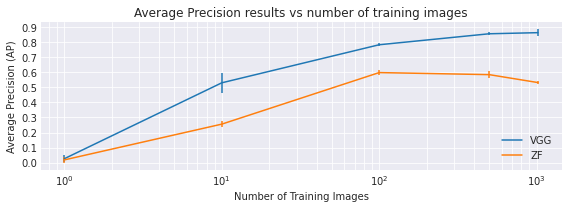

In [13]:
# Results of run
x =  np.array([1, 10, 100, 500, 1020]) # Number of training images

y_vgg_runs = np.array([ [0.01, 0.448, 0.769, 0.841, 0.867],
                        [0.059, 0.535, 0.797, 0.862, 0.891],
                        [0.009, 0.608, 0.784, 0.866, 0.833]  ])
y_vgg_mean = np.mean(y_vgg_runs, axis=0)
y_vgg_std = np.std(y_vgg_runs, axis=0)

y_zf_runs = np.array([ [0, 0.226, 0.577, 0.616, 0.529],
                        [0.009, 0.272, 0.595, 0.563, 0.520],
                        [0.045, 0.269, 0.623, 0.575, 0.547]])
y_zf_mean = np.mean(y_zf_runs, axis=0)
y_zf_std = np.std(y_zf_runs, axis=0)


# Plot
plt.figure(figsize=(8, 3))
plt.xscale('log')
plt.title("Average Precision results vs number of training images")
plt.xlabel("Number of Training Images")
plt.ylabel("Average Precision (AP)")
plt.yticks((0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9))
plt.errorbar(x, y_vgg_mean, yerr = y_vgg_std, label="VGG" )
plt.errorbar(x, y_zf_mean, yerr = y_zf_std, label="ZF" )
plt.legend(loc=4);
plt.tight_layout()
plt.grid(True, which="both")


# Change legend output
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
new_handles = []

for h in handles:
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])
    else:
        new_handles.append(h)

ax.legend(new_handles, labels, loc=4);

In [14]:
# Load one Model
model_vgg = initialize_model("vgg")
model_vgg.load_state_dict(torch.load("Saved_models/vgg__1020__16-04-2021-1737.pt"), strict=False)

model_zf = initialize_model("zf")
model_zf.load_state_dict(torch.load("Saved_models/zf__1020__16-04-2021-1534.pt"), strict=False)

<All keys matched successfully>

In [15]:
# NMS
def NMS(boxes, scores, iou = 0.2):
    indices = nms(boxes = boxes, scores = scores, iou_threshold=iou)
    new_boxes = boxes[indices]
    
    return new_boxes

In [16]:
# Get new image
images, targets = next(iter(data_loader)) # Load next data

In [17]:
# Forward Pass on Trained Model
ForwardTest = 1

if ForwardTest:
    model_vgg.eval()
    predictions_vgg = model_vgg(images)           # Returns predictions
    predictions_vgg_nms = NMS(boxes = predictions_vgg[0]['boxes'], scores = predictions_vgg[0]['scores'])
    
    model_zf.eval()
    predictions_zf = model_zf(images)           # Returns predictions
    predictions_zf_nms = NMS(boxes = predictions_zf[0]['boxes'], scores = predictions_zf[0]['scores'])    
    

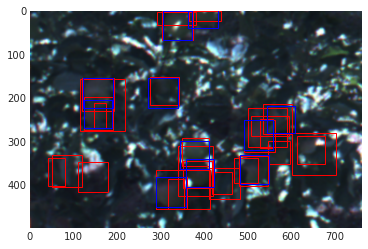

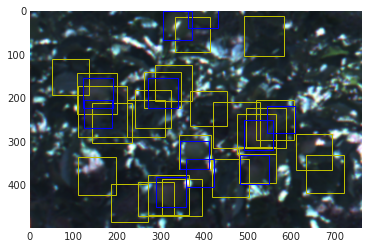

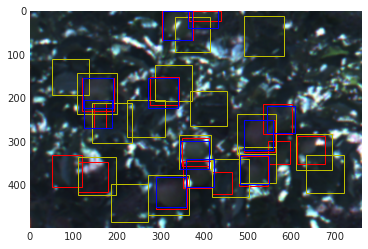

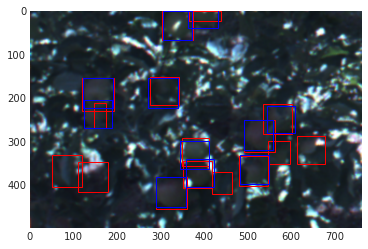

In [18]:
Visualise_Image(images, targets[0], predictions_vgg = None, predictions_zf = None) # only labels

Visualise_Image(images, targets[0], predictions_vgg = predictions_vgg[0]['boxes'], predictions_zf = predictions_zf[0]['boxes']) # both
Visualise_Image(images, targets[0], predictions_vgg = predictions_vgg[0]['boxes'], predictions_zf = None) # only vgg
Visualise_Image(images, targets[0], predictions_vgg = None, predictions_zf = predictions_zf[0]['boxes']) # only zf

Visualise_Image(images, targets[0], predictions_vgg = predictions_vgg_nms, predictions_zf = predictions_zf_nms) # both
Visualise_Image(images, targets[0], predictions_vgg = predictions_vgg_nms, predictions_zf = None) # only vgg
Visualise_Image(images, targets[0], predictions_vgg = None, predictions_zf = predictions_zf_nms) # only zf